## Problem Background:
* Machine learning techniques are a primary tool for analyzing network traffic and detecting cybersecurity attacks. Given that these cybersecurity attacks have become more sophisticated and distributed over the years due to our increasingly data driven society, network security has become a very significant issue. Military, government, and commercial operations as well as civilians are affected daily by cybersecurity vulnerabilities. The National Institute of Standards in Technology reported that in 2017, American companies lost 65.6 billion dollars from IT attacks [1]. Many companies have invested in automation techniques, but the security industry for the most part is dependent on costly handling of enormous datasets that is done by hand. Most of today’s machine-learning approaches rely on “anomaly detection,” which tends to trigger false positives that both create distrust of the system and end up having to be investigated by humans anyway [2]. Therefore, a solution for identifying malicious attacks through a more efficient, effective and lower cost method is greatly needed.

## Dataset:
* The dataset used for this project is the NSL-KDD dataset, which is an improved version of the KDD’99 data set that was used to build a predictive model capable of detecting “bad'” connections (intrusions) and “good'” or normal connections. The improved dataset does not include redundant records in the train set, so the classifiers will not be biased towards more frequent records. In addition, the number of records in the train and test sets are reasonable, making it more affordable to run the experiments on the complete set without the need to randomly select a small portion.The KDD training dataset consists of approximately 4,900,000 single connection vectors each of which contains 41 features and is labeled as either normal or as one of four attack types:
    * Denial of Service Attack (DoS): the attacker makes some computing or memory resource too busy/full to handle legitimate requests or denies legitimate users access to a machine
    * User to Root Attack (U2R): the attacker starts out with access to a normal user account on the system and exploits some vulnerability to gain root access to the system
    * Remote to Local Attack (R2L): the attacker has the ability to send packets to a machine over a network but does not have an account on that machine and exploits some vulnerability to gain local access as a user of that machine
    * Probing Attack: attempt to gather information about a network of computers for the purpose of circumventing security controls
* The KDD dataset has three types of features:
    * Basic features: all the attributes that can be extracted from a TCP/IP connection, most of which lead to an implicit delay in detection
    * Trafﬁc features: features that are computed with respect to a window interval, divided into two groups:
        * same host” features: examine only the connections in the past 2 seconds that have the same destination host as the current connection, also calculate statistics related to protocol behavior, service, etc.
        * same service” features: examine only the connections in the past 2 seconds that have the same service as the current connection
    * Content features: features to be able to look for suspicious behavior in the data portion of the packets (R2L and U2R), e.g., number of failed login attempts
* How did we get it
* Features / size / background

## Approach
* What have people already done?
    * AI², which incorporates expert input in a system that combines supervised and unsupervised learning to detect 85% of attacks [2].
    * Chowdhury, et al. displays network information as a graph and automatically identify botnet attack by using clustering algorithms.
    
* What is new in your approach?
    * We will develop our project while holding an unbiased and purely educational perspective. Unlike many companies with a lot of stake in this issue, we are not at a major risk of malicious users trying to harm our systems. We plan to use the KDD Cup 1999 Dataset to implement a form of ensemble learning.

* Why do you think you approach can effectively solve the problem?
    * Our goal is purely specific to this data set, so we can take shortcuts without the world crashing down


## Part 1: General
Our goals for this section were to:
1. Explore the dataset
2. Establish a baseline for how well we can classify with minimal modifications

In [3]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import sklearn
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error 
#import xgboost as xgb

In [4]:
traindata = pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None)

['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land' 'loadmodule'
 'spy' 'perl']


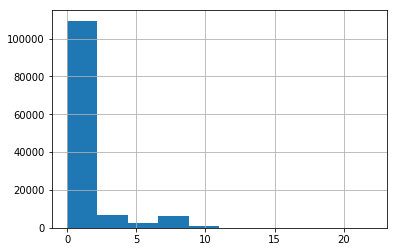

In [5]:
print(traindata[41].unique())
label_map = dict(zip(traindata[41].unique(), range(len(traindata[41].unique()))))
a = traindata.replace(label_map)
a[41].hist()

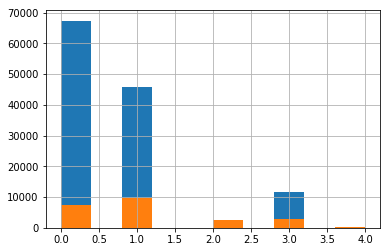

In [10]:
def simplify_label(df):
    attack_dict = {
        'normal': 'normal',

        'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 
        'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',

        'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'satan': 'Probe',
        'mscan': 'Probe', 'saint': 'Probe',

        'ftp_write': 'R2L', 'guess_passwd': 'R2L', 'imap': 'R2L', 'multihop': 'R2L', 'phf': 'R2L',
        'spy': 'R2L', 'warezclient': 'R2L', 'warezmaster': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
        'snmpgetattack': 'R2L', 'snmpguess': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'worm': 'R2L',

        'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R',
        'httptunnel': 'U2R', 'ps': 'U2R', 'sqlattack': 'U2R','xterm': 'U2R'
    }

    attack_simp = {}
    for a in df[41].unique():
        if attack_dict[a] is not None:
            attack_simp[a] = attack_dict[a]

    df2 = df.replace(attack_simp)
    label_map = dict(zip(df2[41].unique(), range(len(df2[41].unique()))))
    df2 = df2.replace(label_map)
    return df2

    
traindata = simplify_label(pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None))
testdata = simplify_label(pd.read_csv('NSL-KDD/KDDTest+.csv', header=None))
traindata[41].hist()
testdata[41].hist()

In [11]:
def encode(df):
#     a = df.drop(42, axis=1)
    a = df
    protocol_map = dict(zip(df[1].unique(), range(len(df[1].unique()))))
    service_map = dict(zip(df[2].unique(), range(len(df[2].unique()))))
    flag_map = dict(zip(df[3].unique(), range(len(df[3].unique()))))
    # replace the symbolic features
    a = a.replace(flag_map)
    a = a.replace(protocol_map)
    a = a.replace(service_map)
    # replace the labels (22 -> 5)
    label_map = dict(zip(a[41].unique(), range(len(a[41].unique()))))
    a = a.replace(label_map)
    return a

In [12]:
def get_accuracy(train_set, test_set, model):  
    X = train_set.iloc[:,0:41].join(train_set.iloc[:,42])
    Y = train_set.iloc[:,41]
    scaler = Normalizer().fit(X)
    trainX = scaler.transform(X)
    model.fit(X, Y)
    Y_test = test_set.iloc[:,41]
    X_test = test_set.iloc[:,0:41].join(test_set.iloc[:,42])
    scaler = Normalizer().fit(X_test)
    trainX = scaler.transform(X_test)
    predicted = model.predict(X_test)
    return accuracy_score(Y_test, predicted)

In [13]:
train = encode(traindata)
test = encode(testdata)

In [14]:
models = [GaussianNB(), DecisionTreeClassifier(), KNeighborsClassifier(), 
          AdaBoostClassifier(n_estimators=50), AdaBoostClassifier(n_estimators=100), 
          AdaBoostClassifier(n_estimators=150), RandomForestClassifier(n_estimators=50),
          RandomForestClassifier(n_estimators=100), RandomForestClassifier(n_estimators=150)]

acc_list = []
for m in models:
    score = get_accuracy(train, test, m)
    acc_list.append(score)

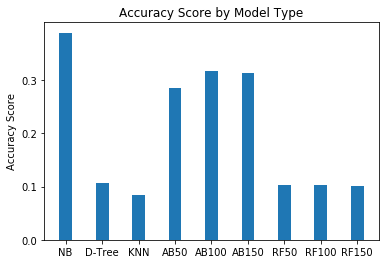

In [15]:
ind = np.arange(len(acc_list))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, acc_list, width)

plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model Type')
plt.xticks(ind, ('NB', 'D-Tree', 'KNN', 'AB50', 'AB100', 'AB150', 'RF50', 'RF100', 'RF150'))
plt.yticks(np.arange(0, 0.4, 0.1))

plt.show()
# Note: best = 25%, about equivalent to random

### Part 1 Takeaway:
The AdaBoost classifier was slightly better than randomly selecting a label (25% vs. 20%), however the rest of our models are underperforming.

## Part 2: Specific
* Exploring ways to simplify and boost the accuracy of our best model

In [16]:
# Isolate only DoS labels
def take_DoS(df):
    attack_dict = {}
    for a in df[41].unique():
        attack_dict[a] = False

    attack_dict['normal'] = True
    attack_dict['back'] = True
    attack_dict['land'] = True
    attack_dict['neptune'] = True
    attack_dict['pod'] = True
    attack_dict['smurf'] = True
    attack_dict['teardrop'] = True
    attack_dict['mailbomb'] = True
    attack_dict['apache2'] = True
    attack_dict['processtable'] = True
    attack_dict['udpstorm'] = True    

    a_list = [key for key, value in attack_dict.items() if attack_dict[key] == True]
    a = df[df[41].isin(a_list)]
    return a

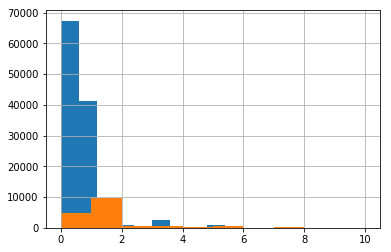

In [82]:
traindata = pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None)
testdata = pd.read_csv('NSL-KDD/KDDTest+.csv', header=None)
train = encode(take_DoS(traindata))
test = encode(take_DoS(testdata))
train[41].hist()
test[41].hist()

In [83]:
get_accuracy(train, test, AdaBoostClassifier(n_estimators=100))
# makes sense - 5 labels -> 11

0.013455265610438024

In [90]:
# Convert to binary
def make_binary(df):
    binary_dict = {}
    for label in df[41].unique():
        binary_dict[label] = 0 if label == 'normal' else 1
    a = df.replace(binary_dict)
    return a

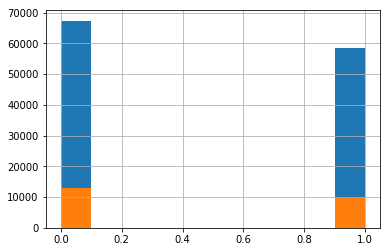

In [93]:
traindata = pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None)
testdata = pd.read_csv('NSL-KDD/KDDTest+.csv', header=None)
train = encode(make_binary(traindata))
test = encode(make_binary(testdata))
train[41].hist()
test[41].hist()

In [95]:
acc_list = []
for m in models:
    score = get_accuracy(train, test, m)
    acc_list.append(score)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


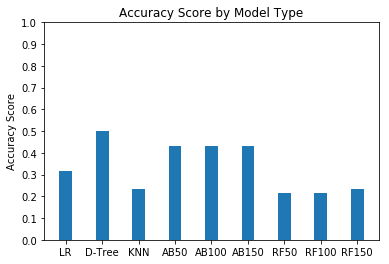

In [96]:
ind = np.arange(len(acc_list))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, acc_list, width)

plt.ylabel('Accuracy Score')
plt.title('Accuracy Score by Model Type')
plt.xticks(ind, ('NB', 'D-Tree', 'KNN', 'AB50', 'AB100', 'AB150', 'RF50', 'RF100', 'RF150'))
plt.yticks(np.arange(0, max(acc_list) + 0.5, 0.1))

plt.show()

In [103]:
traindata = pd.read_csv('NSL-KDD/KDDTrain+.csv', header=None)
testdata = pd.read_csv('NSL-KDD/KDDTest+.csv', header=None)
train = encode(make_binary(take_DoS(traindata)))
test = encode(make_binary(take_DoS(testdata)))
score = get_accuracy(train, test, GaussianNB())

In [106]:
score


0.37971808014911462

## Conclusion
* How did we evaluate our approach?
* What are results?
* How did we compare our method to other methods?
* What is your major achievement?
* Future work?